In [1]:
from pathlib import Path

data_root = Path('Messidor Database')

In [19]:
def get_leaf_subdirectories(root):
    return [
        str(subdir)
        for subdir in root.rglob('*')
        if (subdir.is_dir()
            and not any(child.is_dir() and child.name != 'processed' for child in subdir.iterdir())
            and subdir.name != 'processed')
    ]

data_dirs = get_leaf_subdirectories(data_root)

In [20]:
data_dirs

["Messidor Database/1. Service d'Ophtalmologie - Hôpital Lariboisière Paris/Base11",
 "Messidor Database/1. Service d'Ophtalmologie - Hôpital Lariboisière Paris/Base12",
 "Messidor Database/1. Service d'Ophtalmologie - Hôpital Lariboisière Paris/Base13",
 "Messidor Database/1. Service d'Ophtalmologie - Hôpital Lariboisière Paris/Base14",
 "Messidor Database/2. Service d'Ophtalmologie - E3063 Faculté de Médecine St Étienne/Base21",
 "Messidor Database/2. Service d'Ophtalmologie - E3063 Faculté de Médecine St Étienne/Base22",
 "Messidor Database/2. Service d'Ophtalmologie - E3063 Faculté de Médecine St Étienne/Base23",
 "Messidor Database/2. Service d'Ophtalmologie - E3063 Faculté de Médecine St Étienne/Base24",
 'Messidor Database/3. LaTIM - CHRU de Brest/Base31',
 'Messidor Database/3. LaTIM - CHRU de Brest/Base32',
 'Messidor Database/3. LaTIM - CHRU de Brest/Base33',
 'Messidor Database/3. LaTIM - CHRU de Brest/Base34']

In [21]:
import pandas as pd

records = []

for leaf_dir in data_dirs:
    folder_name = leaf_dir.rsplit('/', 1)[-1]
    annotation_file = Path(leaf_dir) / f"Annotation {folder_name}.xls"

    if not annotation_file.exists():
        print(f"Warning: Missing annotation file in {leaf_dir}")
        continue

    try:
        df = pd.read_excel(annotation_file)
    except Exception as e:
        print(f"Failed to read {annotation_file}: {e}")
        continue

    if "Image name" not in df.columns or "Retinopathy grade" not in df.columns:
        raise ValueError(
            f"Missing expected columns in {annotation_file}. "
            f"Found columns: {list(df.columns)}"
        )

    for _, row in df.iterrows():
        img_file = Path(leaf_dir) / 'processed' / row["Image name"]
        label = row["Retinopathy grade"]
        records.append({
            "img_dir": str(img_file),
            "label": label
        })

df_messidor = pd.DataFrame(records)

In [22]:
df_messidor.to_csv('df_messidor.csv', index=False)

---

In [3]:
from PIL import Image, ImageOps
import numpy as np
import cv2

class TrimAndPad:
    def __init__(self, width=224, height=224, black_thresh=15, speckle_size=10):
        """
        Args:
            width (int): target output width
            height (int): target output height
            black_thresh (int): grayscale threshold below which pixels are "black"
            speckle_size (int): kernel size for removing small speckles
        """
        self.width = width
        self.height = height
        self.black_thresh = black_thresh
        # OpenCV structuring element for opening
        self.kernel = cv2.getStructuringElement(
            cv2.MORPH_RECT, (speckle_size, speckle_size)
        )

    def __call__(self, img: Image.Image):
        # 1) Convert to gray OpenCV image
        gray = np.array(img.convert("L"))

        # 2) Binary threshold
        _, mask = cv2.threshold(
            gray,
            self.black_thresh,
            255,
            cv2.THRESH_BINARY
        )

        # 3) Morphological opening to kill tiny speckles
        clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, self.kernel)

        # 4) Find nonzero coords and crop to bbox
        coords = cv2.findNonZero(clean)
        if coords is not None:
            x, y, w, h = cv2.boundingRect(coords)
            img = img.crop((x, y, x + w, y + h))

        # 5) Pad (aspect‐ratio preserving) to desired size
        img = ImageOps.pad(
            img,
            (self.width, self.height),
            color=(0, 0, 0),
            centering=(0.5, 0.5)
        )
        
        return img

trim_and_pad = TrimAndPad(width=768, height=768)

In [4]:
img_dirs = [str(p) for p in data_root.rglob("*.tif")]

In [17]:
img_dirs[700].rsplit('/', 1)[:-1][0]

"Messidor Database/2. Service d'Ophtalmologie - E3063 Faculté de Médecine St Étienne/Base24"

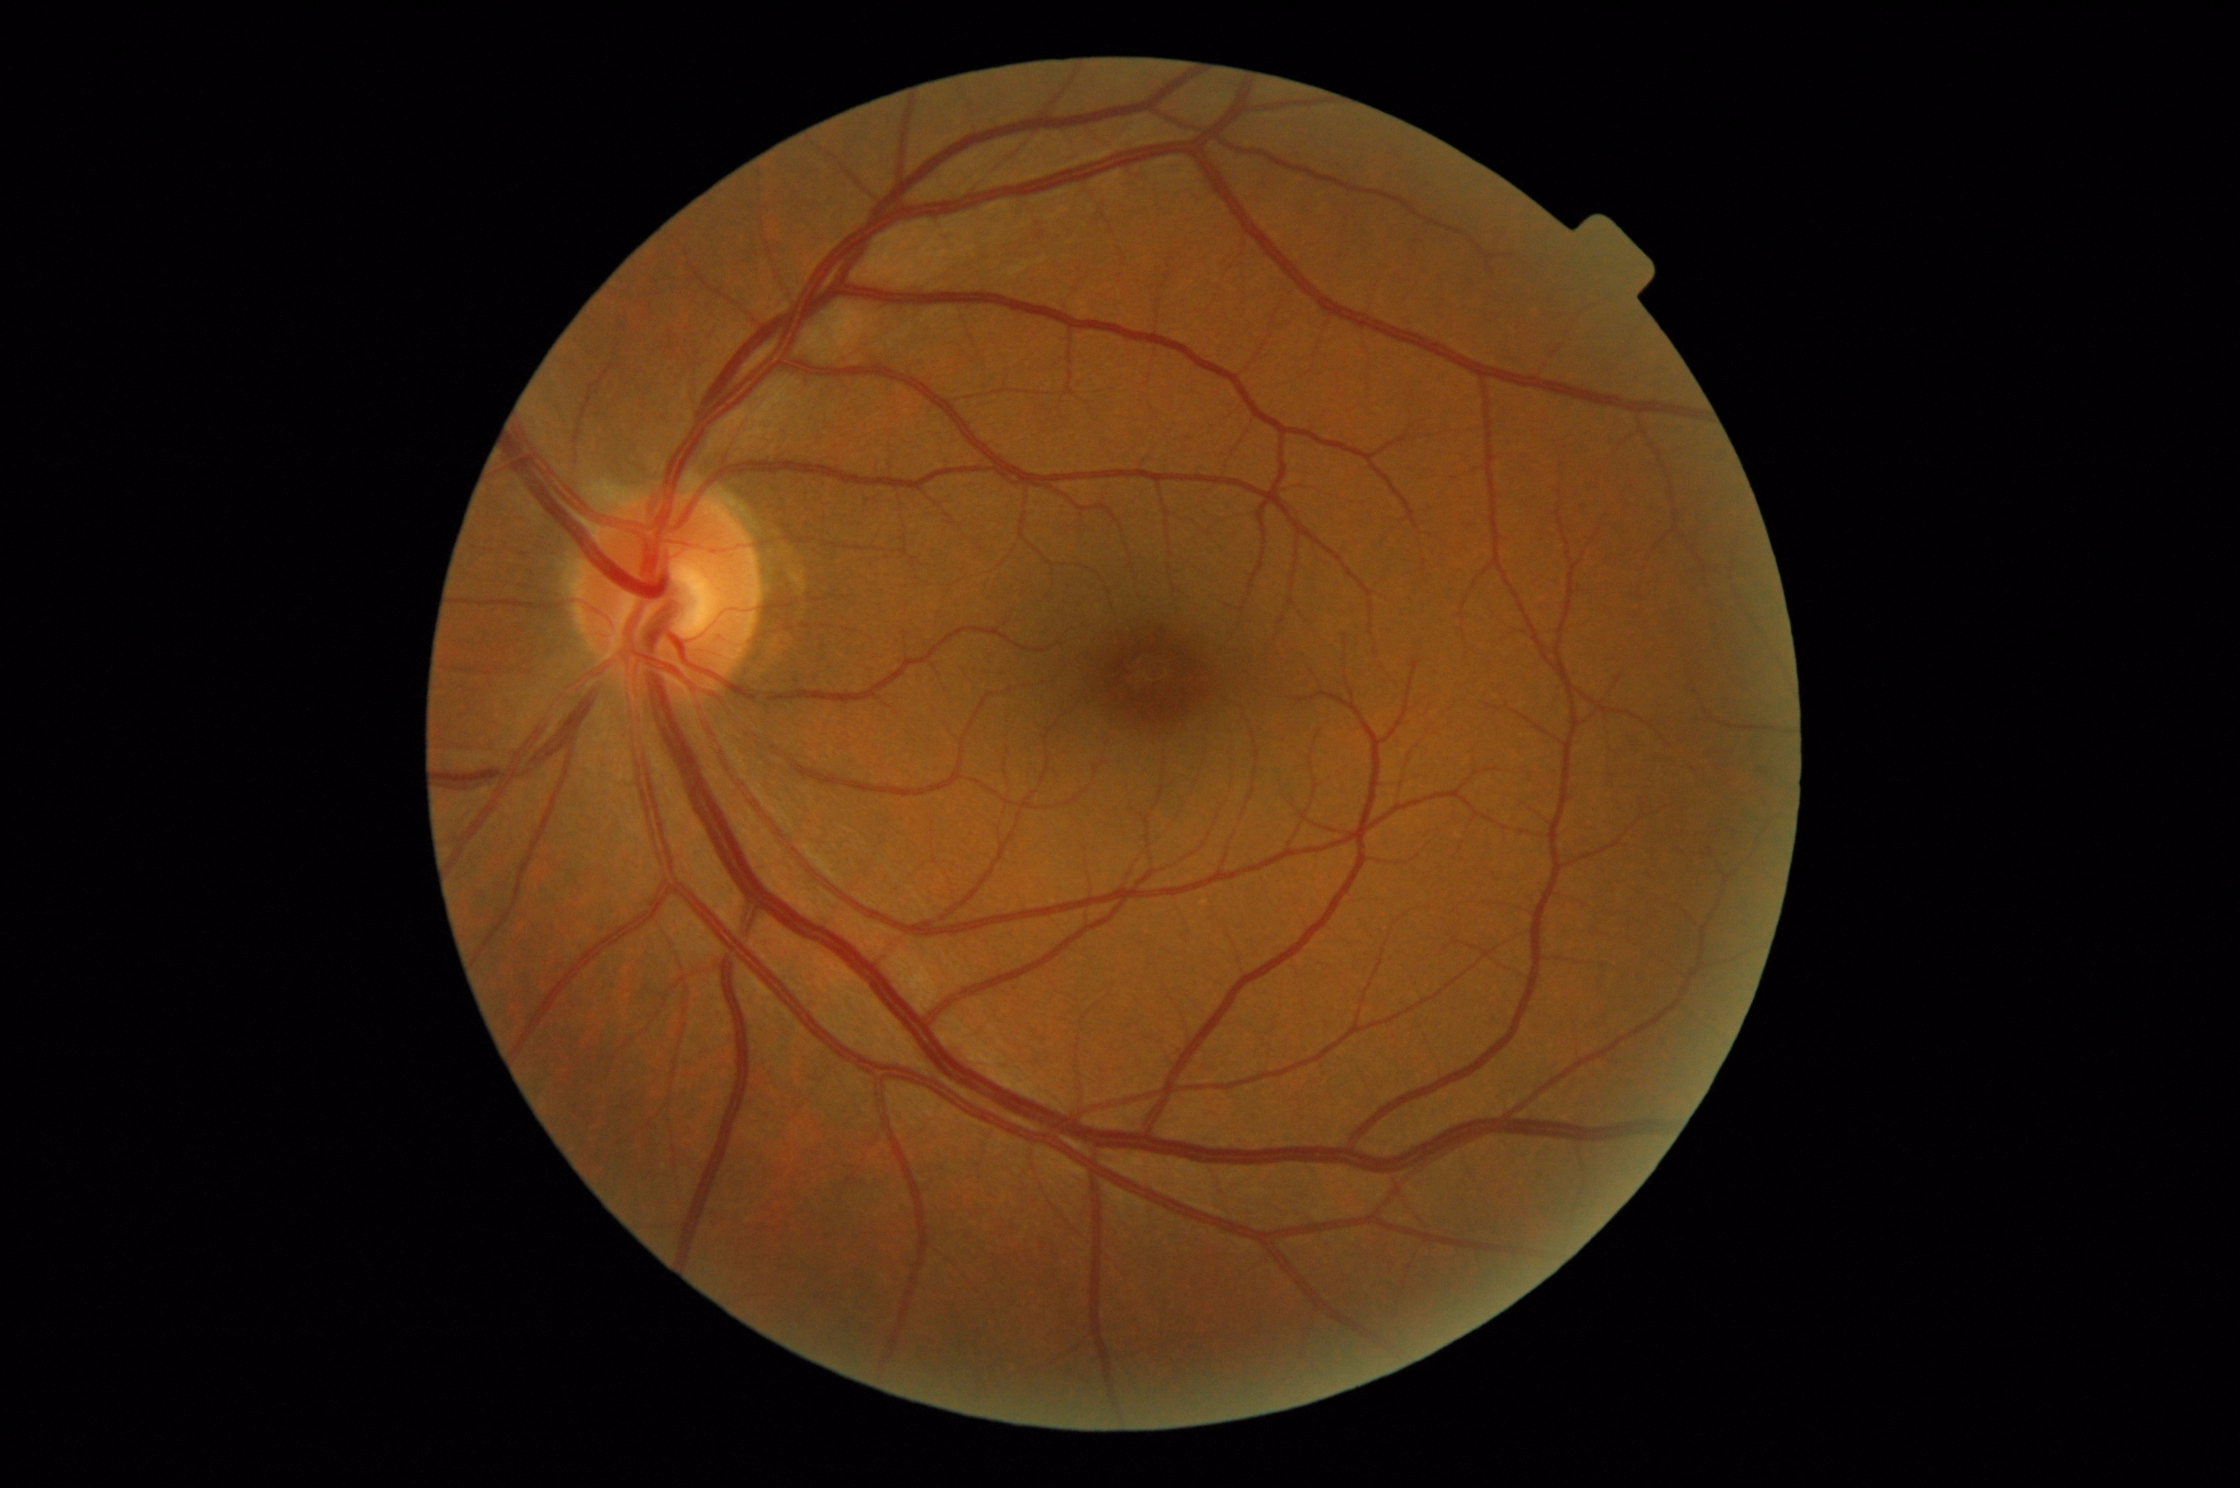

In [6]:
img_path = Path("Messidor Database/1. Service d'Ophtalmologie - Hôpital Lariboisière Paris/Base11") / "20051020_44714_0100_PP.tif"
img = Image.open(img_path).convert("RGB")
img

In [10]:
for dir_path in data_dirs:
    (Path(dir_path) / 'processed').mkdir(parents=True, exist_ok=True)

In [18]:
from joblib import Parallel, delayed

# Assume train_imgs_dir, processed_dir, train_labels, and trim_and_pad are defined
def process_image(img_dir):
    img = Image.open(img_dir).convert("RGB")
    img_folder_dir = img_dir.rsplit('/', 1)[:-1][0]
    img_filename = img_dir.rsplit('/', 1)[-1]
    processed_img = trim_and_pad(img)
    processed_img.save(Path(img_folder_dir) / 'processed' / img_filename)

n_instances = 6  # Adjust based on your system's CPU cores, e.g., 4 for quad-core
Parallel(n_jobs=n_instances)(delayed(process_image)(img_dir) for img_dir in img_dirs)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,